# Imports

In [57]:
import torch
import random
import numpy as np
import tensorflow as tf
import os
from PIL import Image
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Read dataset

In [27]:
dataset_path = 'Dataset/images'

In [28]:
def load_images(path):
  images = []
  for image in os.listdir(path):
      img_path = os.path.join(path, image)

      img = Image.open(img_path)

      images.append(img)

  return images

In [29]:
images= load_images(dataset_path)

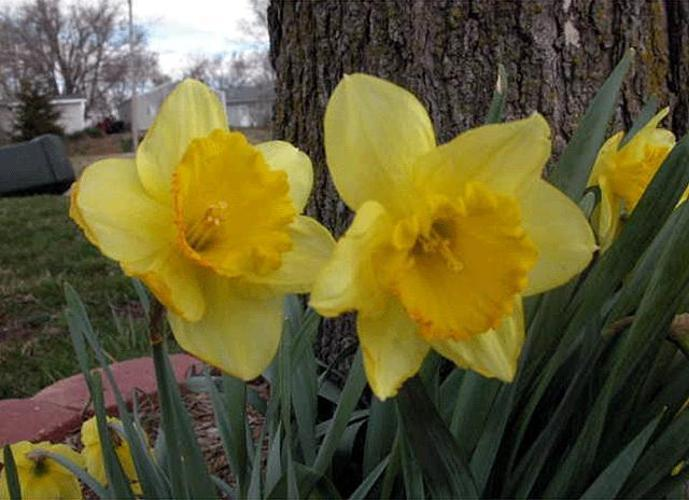

In [30]:
images[0]

In [31]:
def fix_images(images):
  array_img = []
  for img in images:
    new_size = (150, 150)

    resized_img = img.resize(new_size)
    rgb_img = resized_img.convert("RGB")
    array_img.append(np.array(rgb_img))

  return array_img

In [32]:
fixed_images = fix_images(images)

In [33]:
fixed_images[0].shape

(150, 150, 3)

In [34]:
labels = []
for i in range(17):
    labels.extend([i] * 80)

# Training

In [35]:
train_size = int(0.8 * len(fixed_images))
val_size = int(0.1 * len(fixed_images))
test_size = len(fixed_images) - train_size - val_size

# Split the lists
train_images, val_images, test_images = fixed_images[:train_size], fixed_images[train_size:train_size+val_size], fixed_images[train_size+val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size+val_size], labels[train_size+val_size:]


In [36]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(1088, 1088, 136, 136)

In [37]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
train_images = train_images.reshape(-1, 150, 150, 3)
val_images = val_images.reshape(-1, 150, 150, 3)
test_images = test_images.reshape(-1, 150, 150, 3)

In [38]:
base_model = keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 108s 1us/step


In [39]:
for layer in base_model.layers:
    layer.trainable = False

In [41]:
model_1 = Sequential()

# Feature Extraction Stage
model_1.add(base_model)

# Classification Stage
# Construct the head of the model that will be placed on top of the base model
model_1.add(Flatten())
model_1.add(Dense(units=64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(units=17, activation='softmax'))

In [42]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 5, 5, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,048,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,380,529 (85.37 MB)

 Trainable params: 2,049,169 (7.82 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [45]:
train_labels = to_categorical(train_labels, num_classes=17)
val_labels = to_categorical(val_labels, num_classes=17)
test_labels = to_categorical(test_labels, num_classes=17)

In [46]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((1088, 150, 150, 3), (1088, 17), (136, 150, 150, 3), (136, 17))

In [47]:
train_images = keras.applications.efficientnet_v2.preprocess_input(train_images)
val_images = keras.applications.efficientnet_v2.preprocess_input(val_images)
test_images = keras.applications.efficientnet_v2.preprocess_input(test_images)

In [49]:
model_1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [54]:
batch_size = 32
epochs = 5

history = model_1.fit(
    x=train_images, 
    y=train_labels, 
    validation_data=(val_images, val_labels), 
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=[
        EarlyStopping(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 490ms/step - accuracy: 0.7698 - loss: 0.6514 - val_accuracy: 0.1324 - val_loss: 6.5543
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 502ms/step - accuracy: 0.8048 - loss: 0.5930 - val_accuracy: 0.1985 - val_loss: 7.1463
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 493ms/step - accuracy: 0.8418 - loss: 0.4860 - val_accuracy: 0.1324 - val_loss: 9.0296
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 472ms/step - accuracy: 0.8494 - loss: 0.4657 - val_accuracy: 0.1985 - val_loss: 8.0175
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 504ms/step - accuracy: 0.8584 - loss: 0.3813 - val_accuracy: 0.1618 - val_loss: 8.5997
Restoring model weights from the end of the best epoch: 1.


In [55]:
test_loss, test_acc = model_1.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.0000e+00 - loss: 10.3887
Test Loss: 10.57924747467041
Test Accuracy: 0.00%


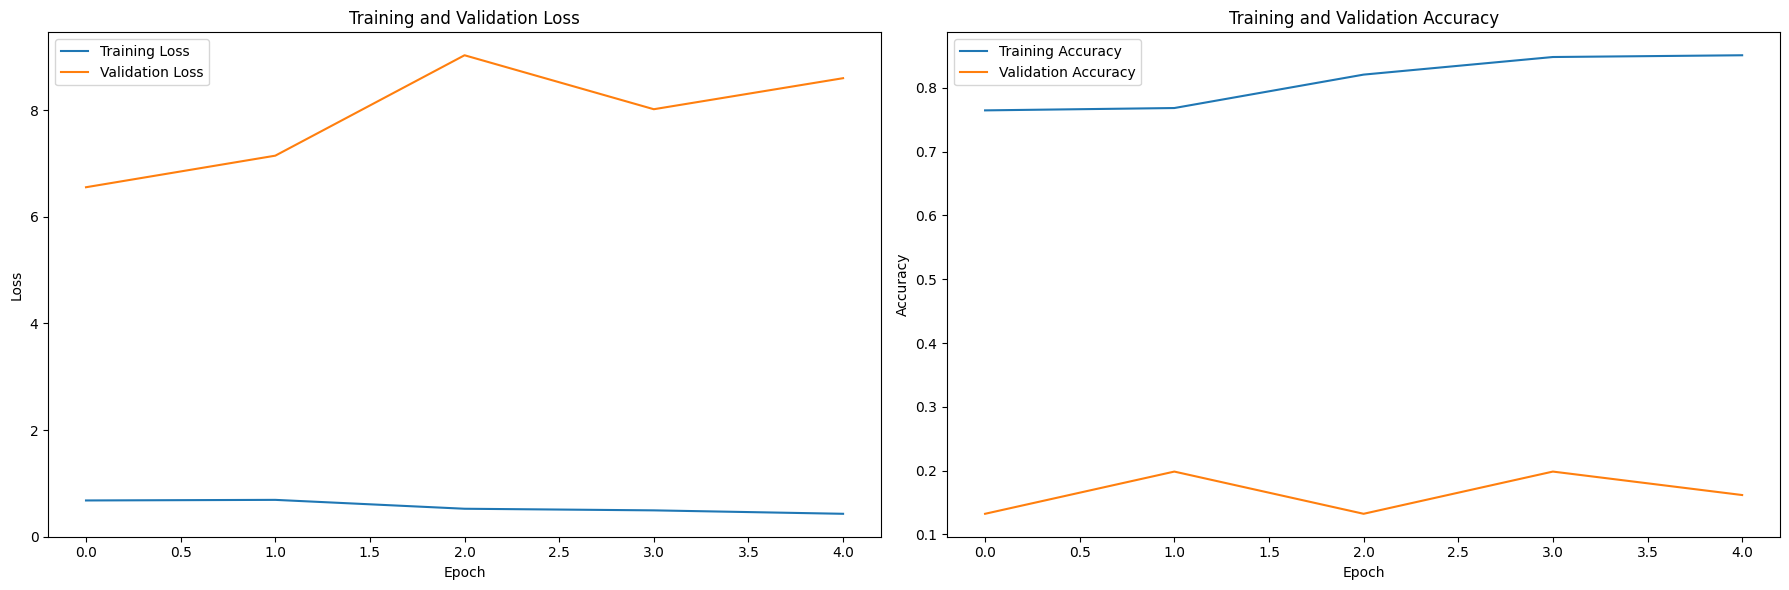

In [58]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training, validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
# Predictions on the test set
test_predictions = model_1.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Convert one-hot encoded labels back to integers
test_true_classes = np.argmax(test_labels, axis=-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 


In [60]:
# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true=test_true_classes, y_pred=test_predictions_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       0.0
          12       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       0.0
          15       0.00      0.00      0.00      56.0
          16       0.00      0.00      0.00      80.0

    accuracy                           0.00     136.0
   macro avg       0.00      0.00      0.00     136.0
wei

c:\Users\Patrickn\.conda\envs\tf_pyT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Patrickn\.conda\envs\tf_pyT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Patrickn\.conda\envs\tf_pyT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Pat

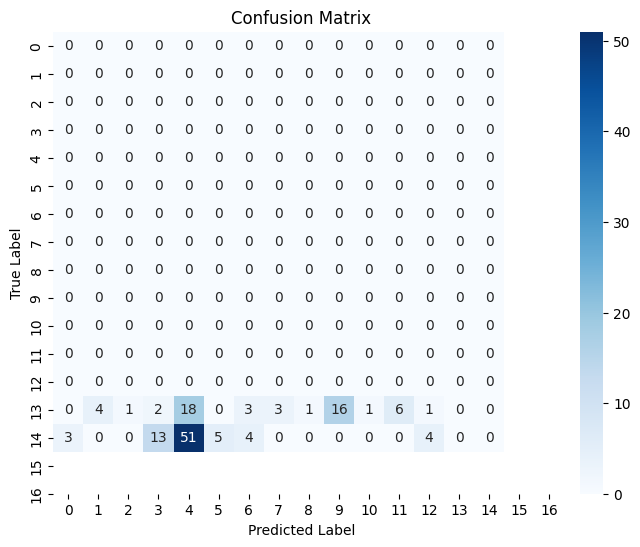

In [62]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_true_classes, test_predictions_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(17), yticklabels=range(17))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Fine-tune the whole network

In [74]:
fine_tune_model = keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

In [75]:
for layer in fine_tune_model.layers:
    layer.trainable = True

In [76]:
model_2 = Sequential()

# Feature Extraction Stage
model_2.add(fine_tune_model)

# Classification Stage
# Construct the head of the model that will be placed on top of the base model
model_2.add(Flatten())
model_2.add(Dense(units=64, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(units=17, activation='softmax'))

In [77]:
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
batch_size = 32
epochs = 5

history = model_2.fit(
    x=train_images, 
    y=train_labels, 
    validation_data = (val_images, val_labels), 
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=[
        EarlyStopping(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=5,
            restore_best_weights=True
            )
        ]
    )

Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.3125 - loss: 2.4013 - val_accuracy: 0.0735 - val_loss: 5.1983
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6814 - loss: 1.0778 - val_accuracy: 0.1618 - val_loss: 7.0679
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7577 - loss: 0.8668 - val_accuracy: 0.1176 - val_loss: 12.7705
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8394 - loss: 0.5724 - val_accuracy: 0.1618 - val_loss: 5.9442
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8675 - loss: 0.4475 - val_accuracy: 0.1838 - val_loss: 6.6975
Restoring model weights from the end of the best epoch: 1.


In [79]:
test_loss, test_acc = model_2.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.0000e+00 - loss: 6.2366
Test Loss: 6.813329696655273
Test Accuracy: 0.00%


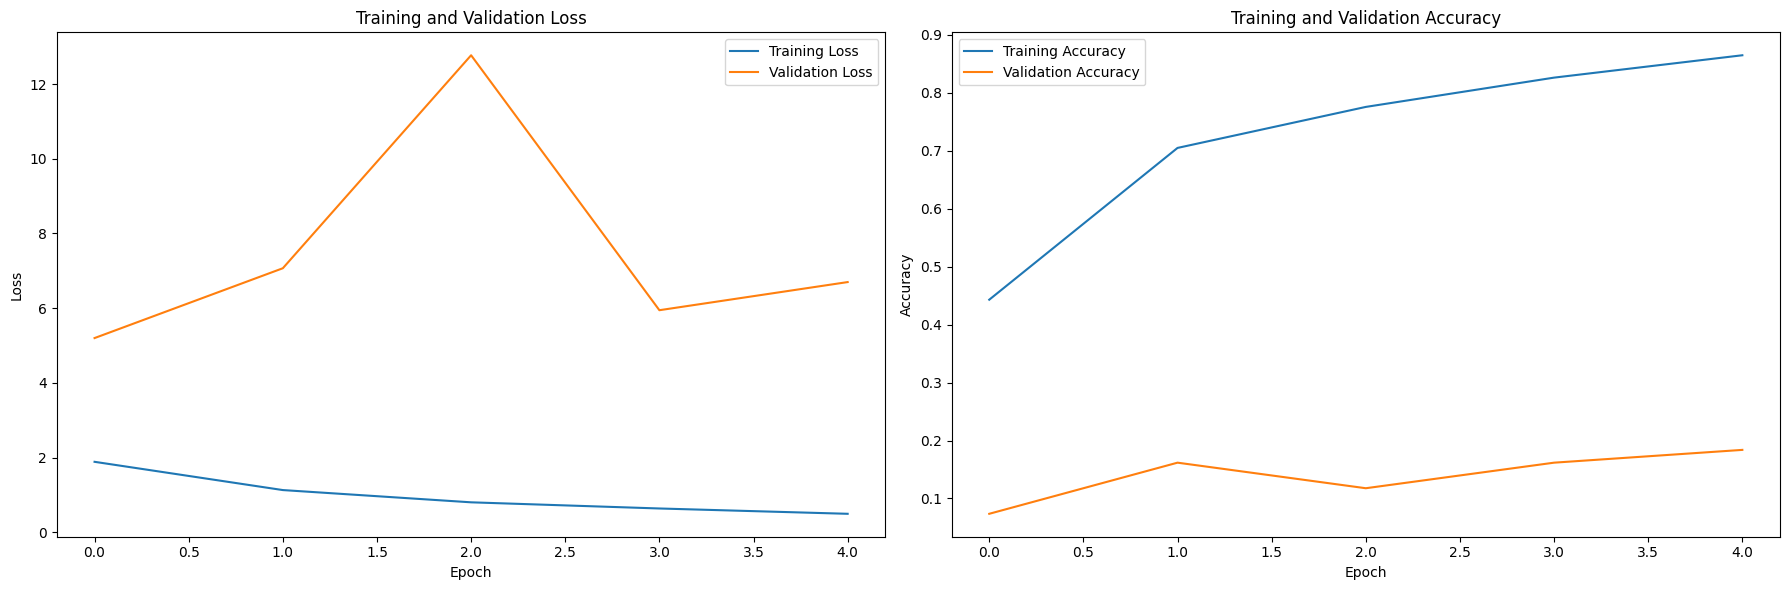

In [80]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training, validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [81]:
# Predictions on the test set
test_predictions = model_2.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Convert one-hot encoded labels back to integers
test_true_classes = np.argmax(test_labels, axis=-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 


In [82]:
# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true=test_true_classes, y_pred=test_predictions_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       0.0
          15       0.00      0.00      0.00      56.0
          16       0.00      0.00      0.00      80.0

    accuracy                           0.00     136.0
   macro avg       0.00      0.00      0.00     136.0
weighted avg       0.00      0.00      0.00     136.0



c:\Users\Patrickn\.conda\envs\tf_pyT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Patrickn\.conda\envs\tf_pyT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Patrickn\.conda\envs\tf_pyT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Pat

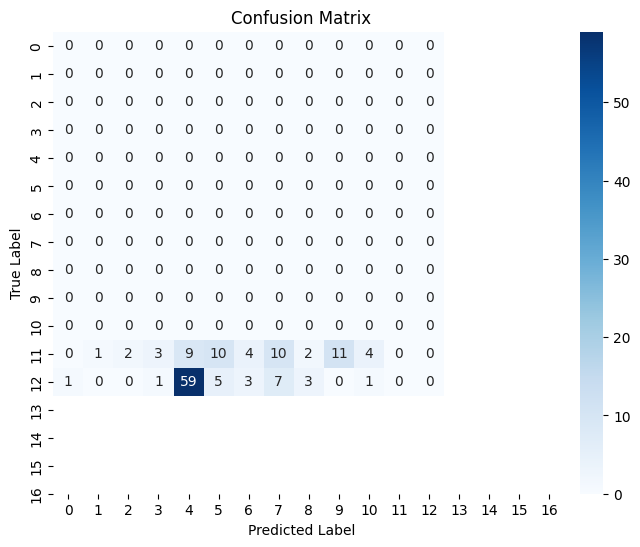

In [83]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_true_classes, test_predictions_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(17), yticklabels=range(17))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()